# Tools


In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn import linear_model
from numpy import mean
from numpy import std
from numpy import array
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

# Data Loading

In [2]:
#Here we are reading the dataset and looking at the first five instances
chd_raw = pd.read_csv('chd-data.csv', sep=',')

# fetch dataset 
chd_raw.head()


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Here we're changing the name of the columns "male" to "gender" (because why the fuck is it called male???) and "TenYearCHD" to "CHD" because it's more simple

In [3]:
chd_raw = chd_raw.rename(columns={'male': 'gender', 'TenYearCHD': 'CHD'})

In [4]:
chd_raw.head()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# Data observation

In [5]:
#Here we are describing the number of instances and columns
chd_raw.shape

(4240, 16)

In [6]:
chd_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  CHD              4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [7]:
chd_raw.describe()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


To see which variables that are categorical

In [8]:
chd_raw._get_numeric_data()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


# Exploratory Data Analysis

Here we're checking how the dataset is distributed on our target variable

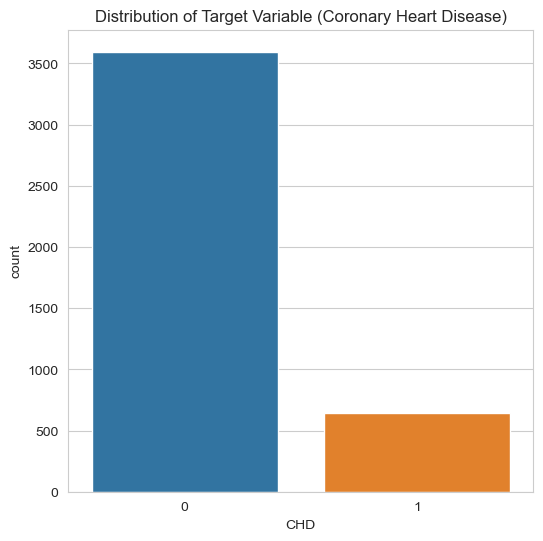

In [9]:
sns.set_style("whitegrid")

# Plot the target variable 'CHD'
plt.figure(figsize=(6, 6))
sns.countplot(x=chd_raw['CHD'])
plt.title('Distribution of Target Variable (Coronary Heart Disease)')
plt.show()

Interpretation of the result:

-
-
-
-
-


Here we're plotting the distribution of the categorical variables

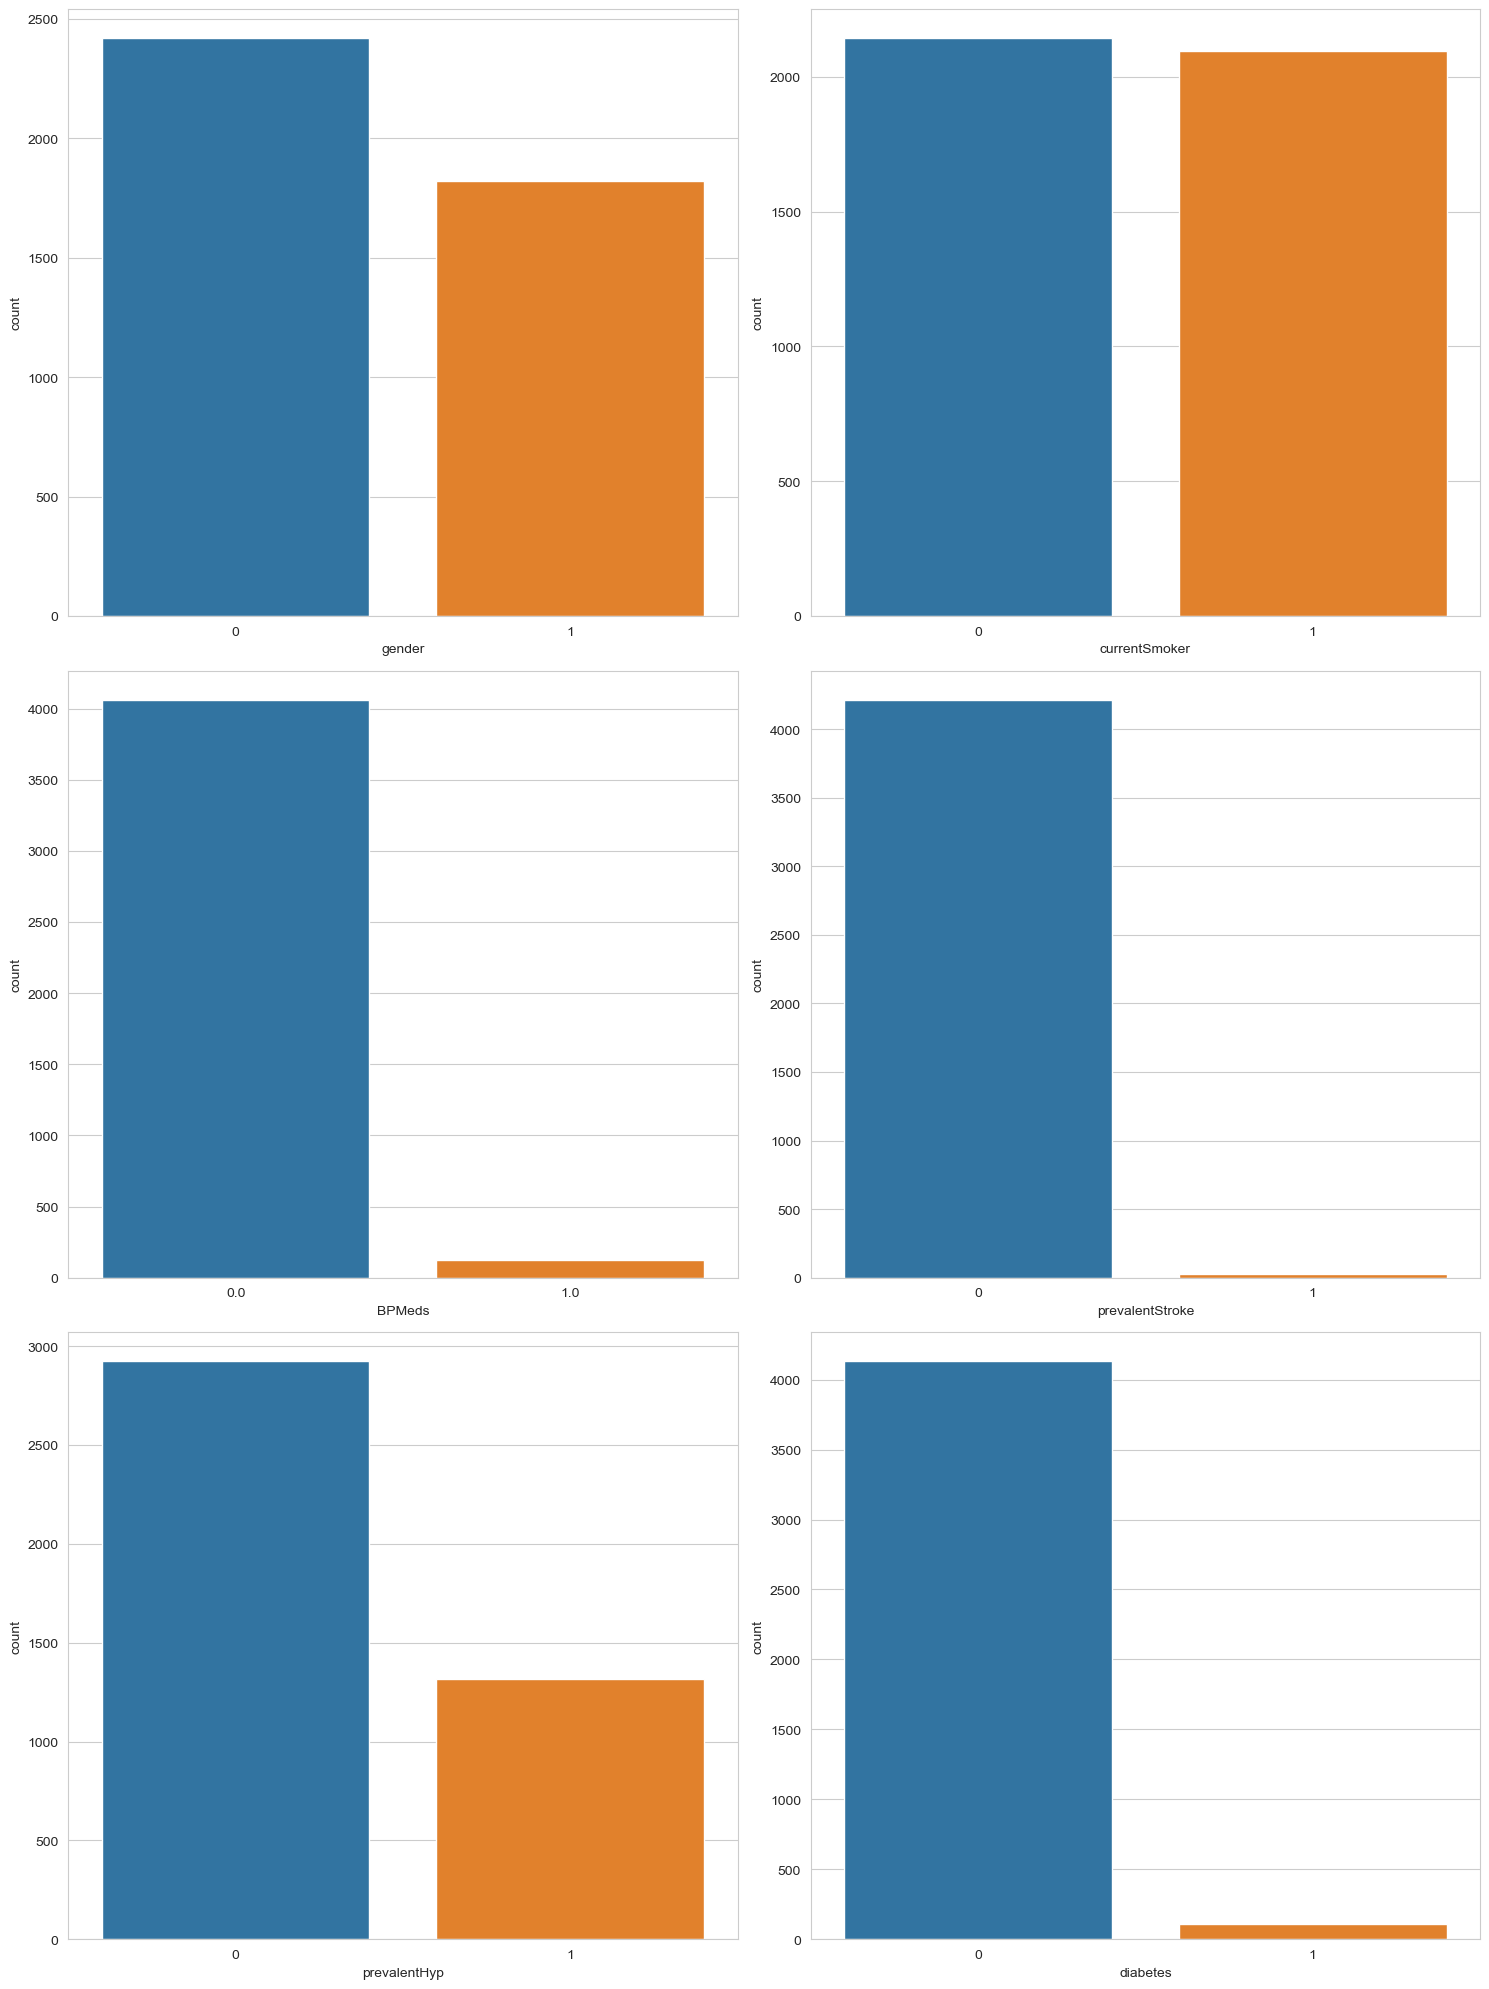

In [10]:
categorical_variables = ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Plotting the bar plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

for var, subplot in zip(categorical_variables, axs.flatten()):
    sns.countplot(x=var, data=chd_raw, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're checking the variables with categorical values against the target variable "CHD"

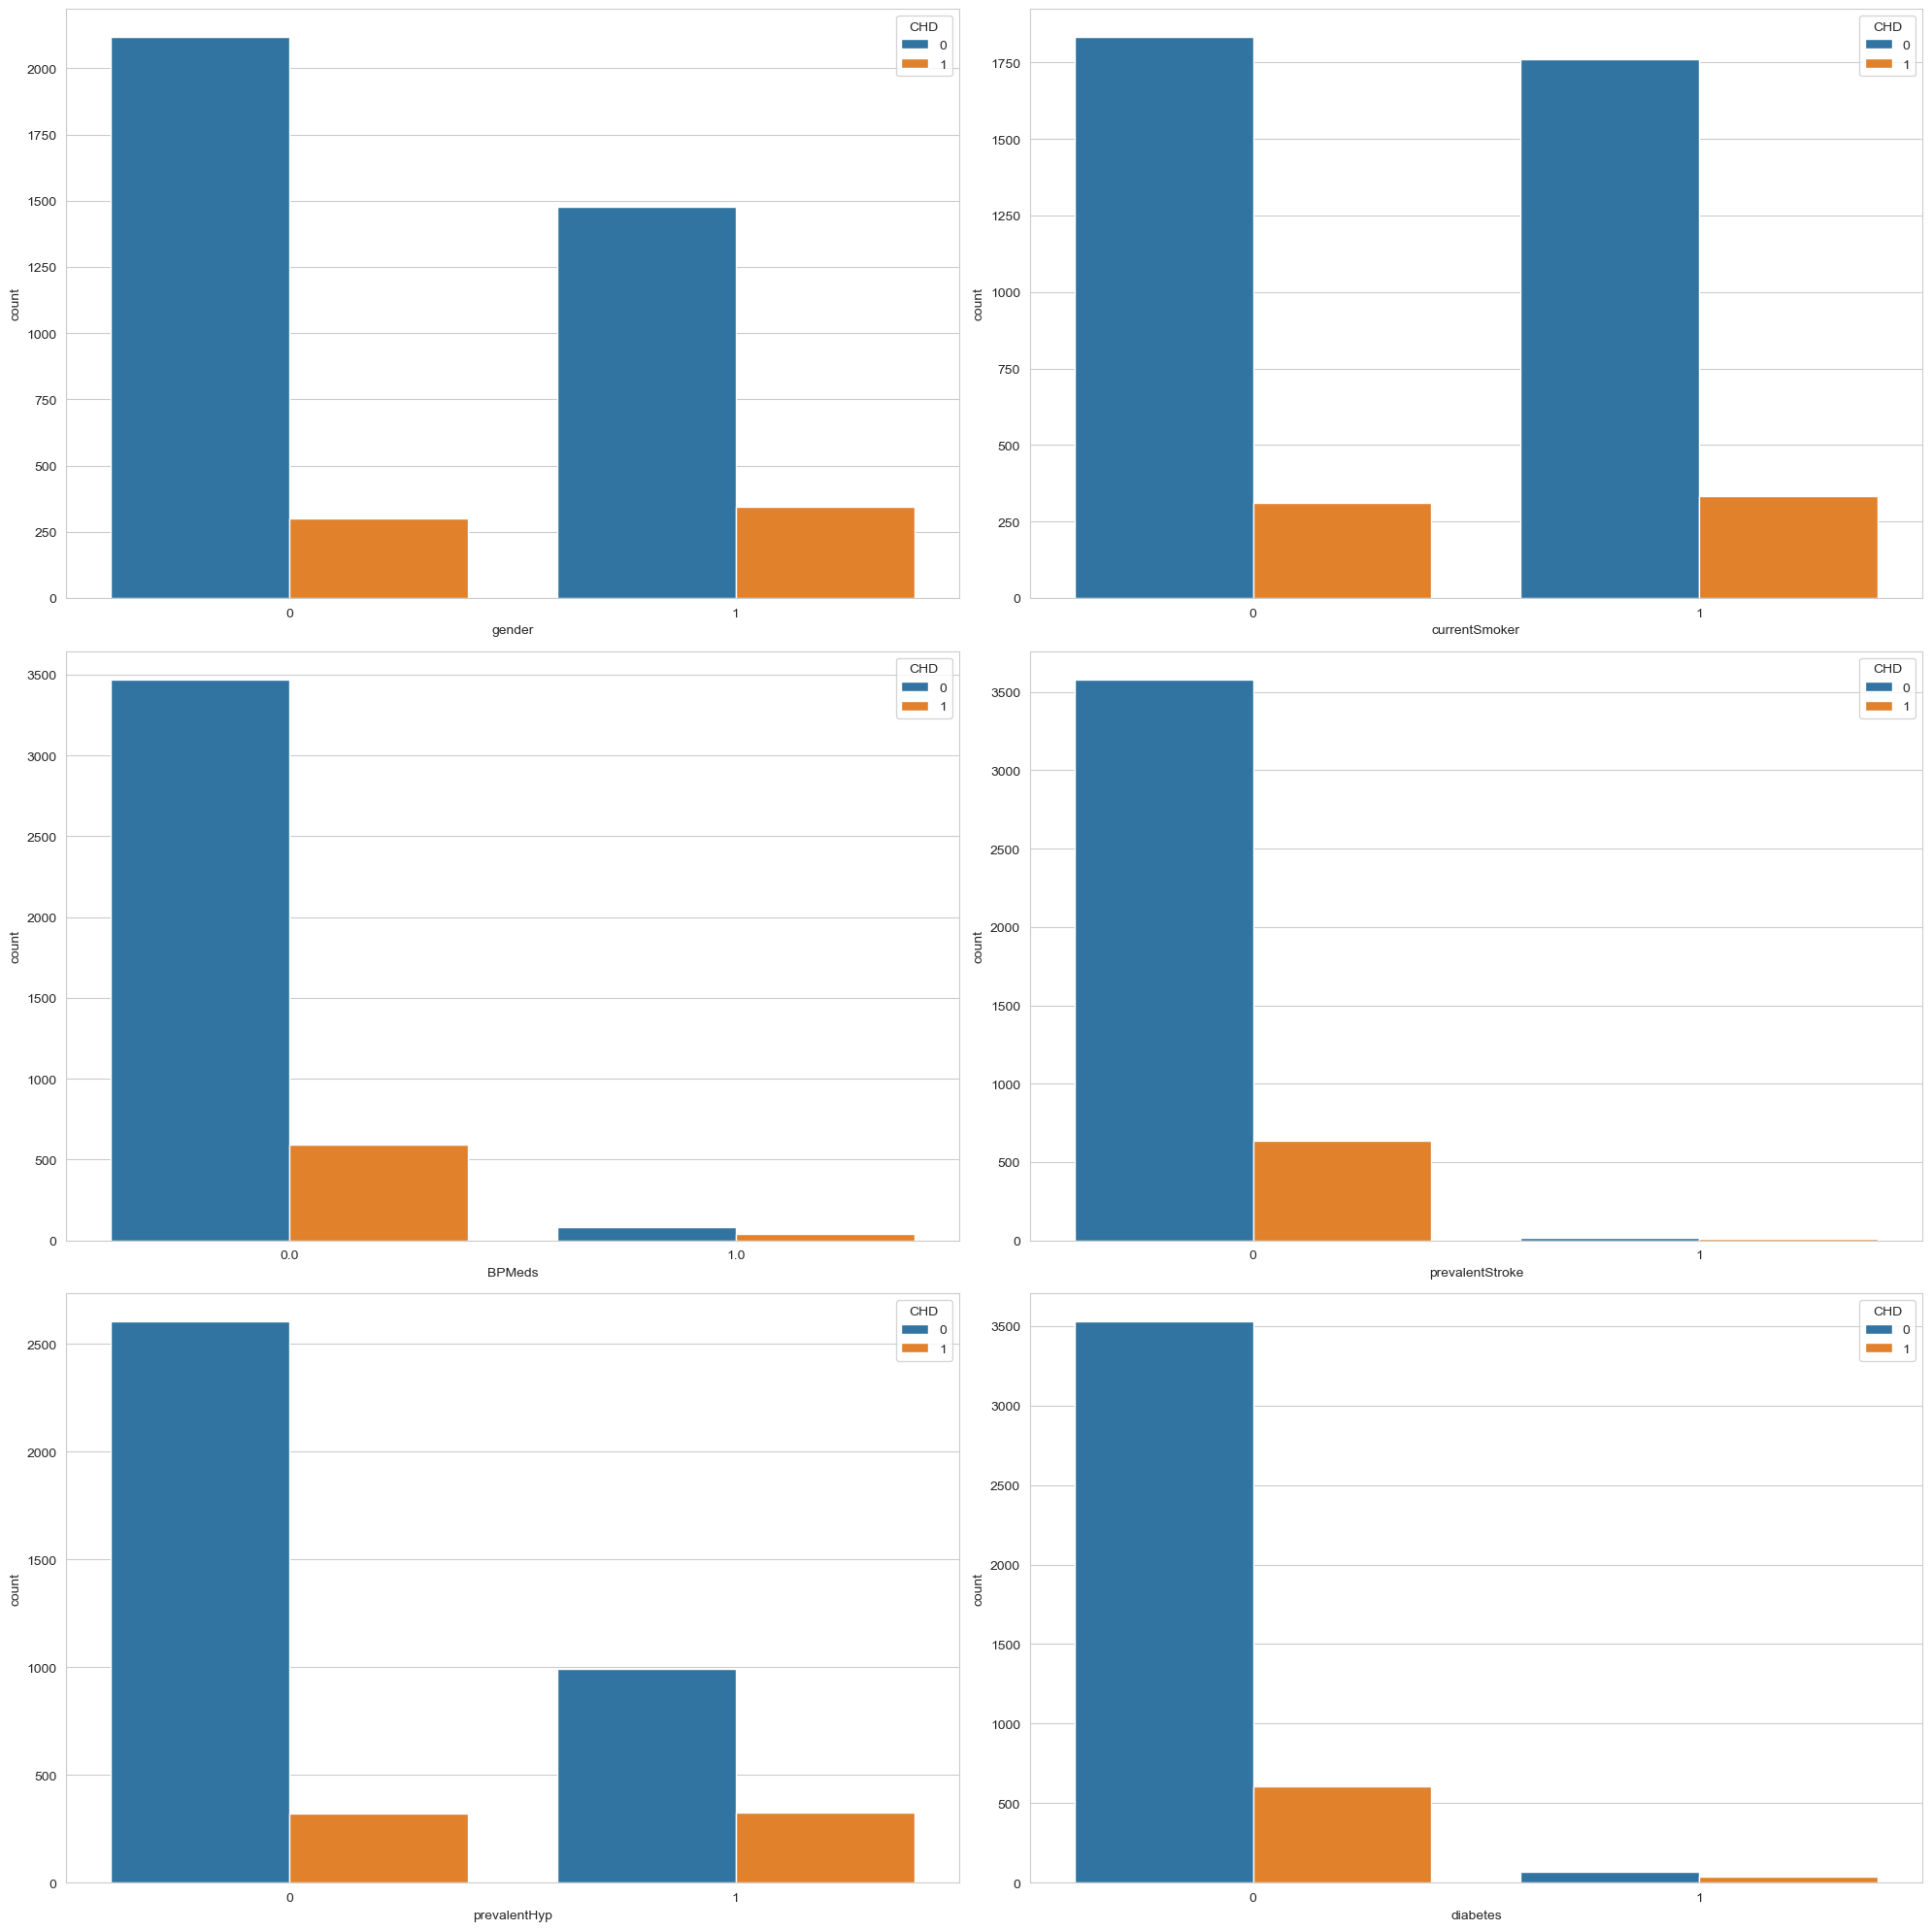

In [11]:
# Plot the categorical variables against the target variable 'CHD'
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for var, subplot in zip(categorical_variables, axs.flatten()):
    sns.countplot(x=chd_raw[var], hue=chd_raw['CHD'], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're ...

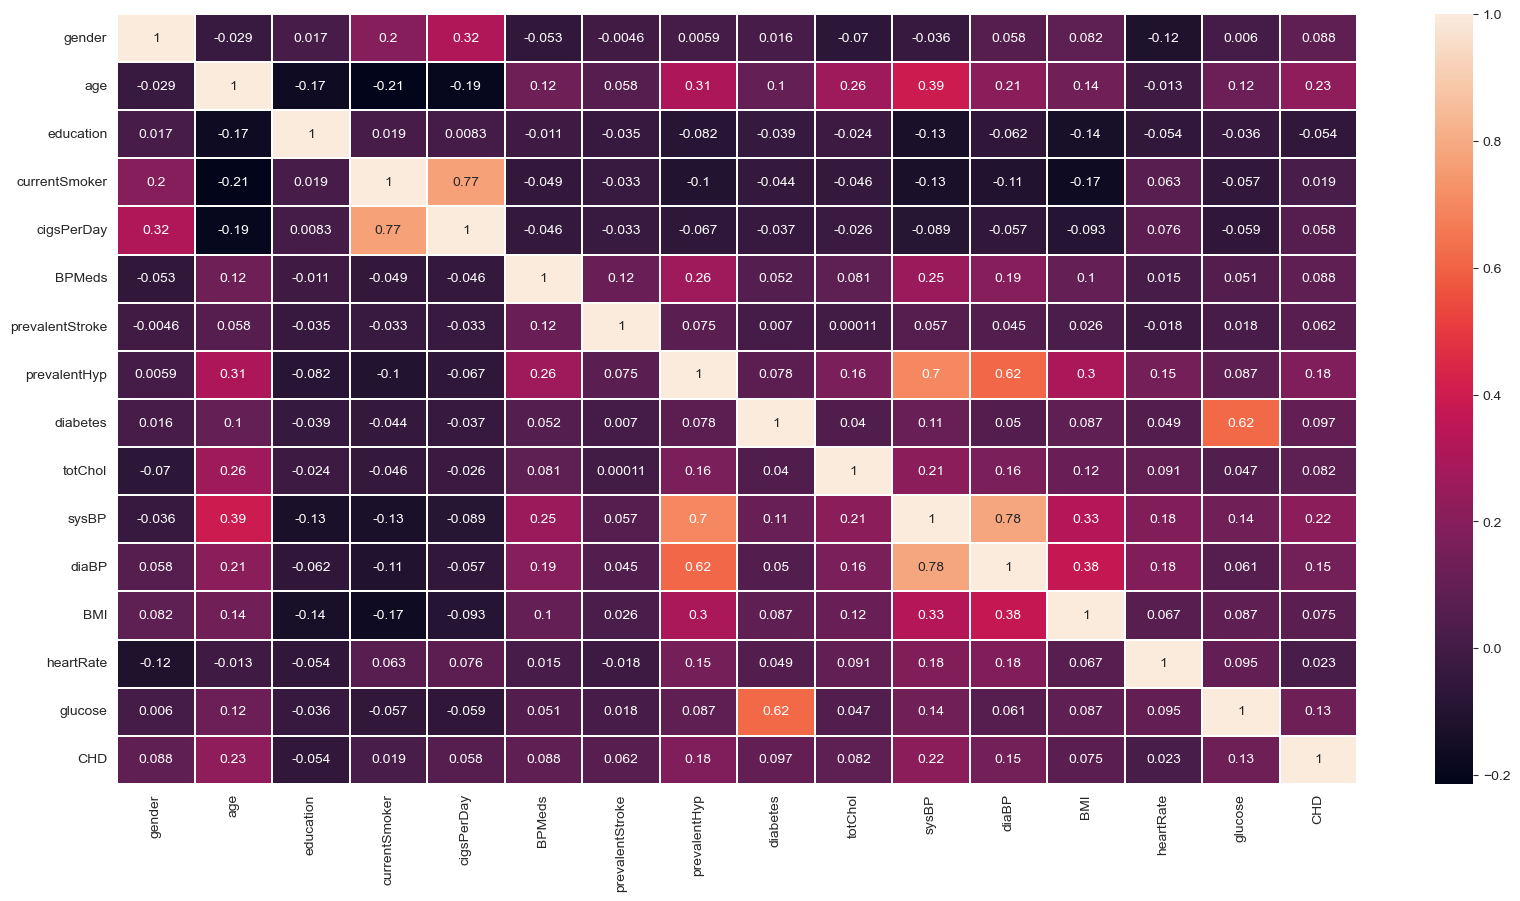

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(chd_raw.corr(),linewidths=0.1,annot=True)
# linewidths is white space between boxes and annot gives value
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're

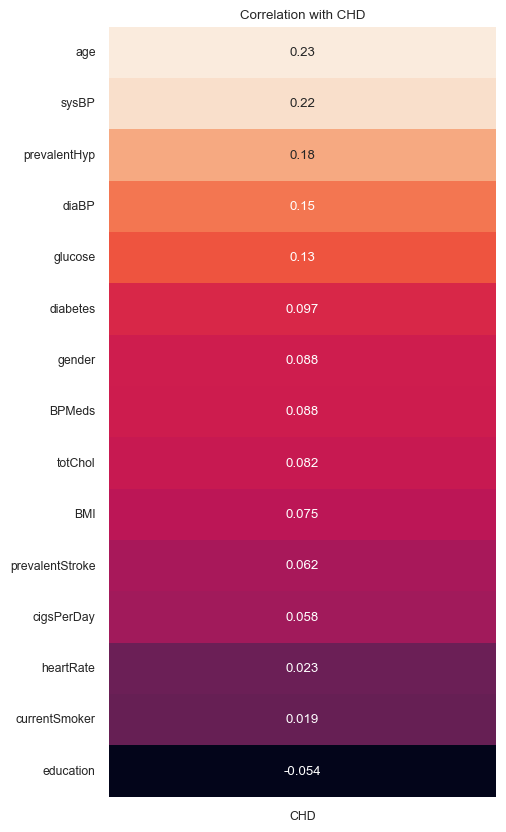

In [13]:
# Compute the correlation of each feature with the target variable 'stroke'
target_corr_one_hot = chd_raw.corr()['CHD'].drop('CHD')

# Sort correlation values in descending order - maybe change names
target_corr_sorted_one_hot = target_corr_one_hot.sort_values(ascending=False)

# Plot a heatmap of the correlations with the target column
plt.figure(figsize=(5, 10))
sns.set(font_scale=0.8)
sns.heatmap(target_corr_sorted_one_hot.to_frame(), annot=True, cbar=False)
plt.title('Correlation with CHD')
plt.show()

Interpretation of the result:

-
-
-
-
-

Here we're creating histograms to see the distribution of data

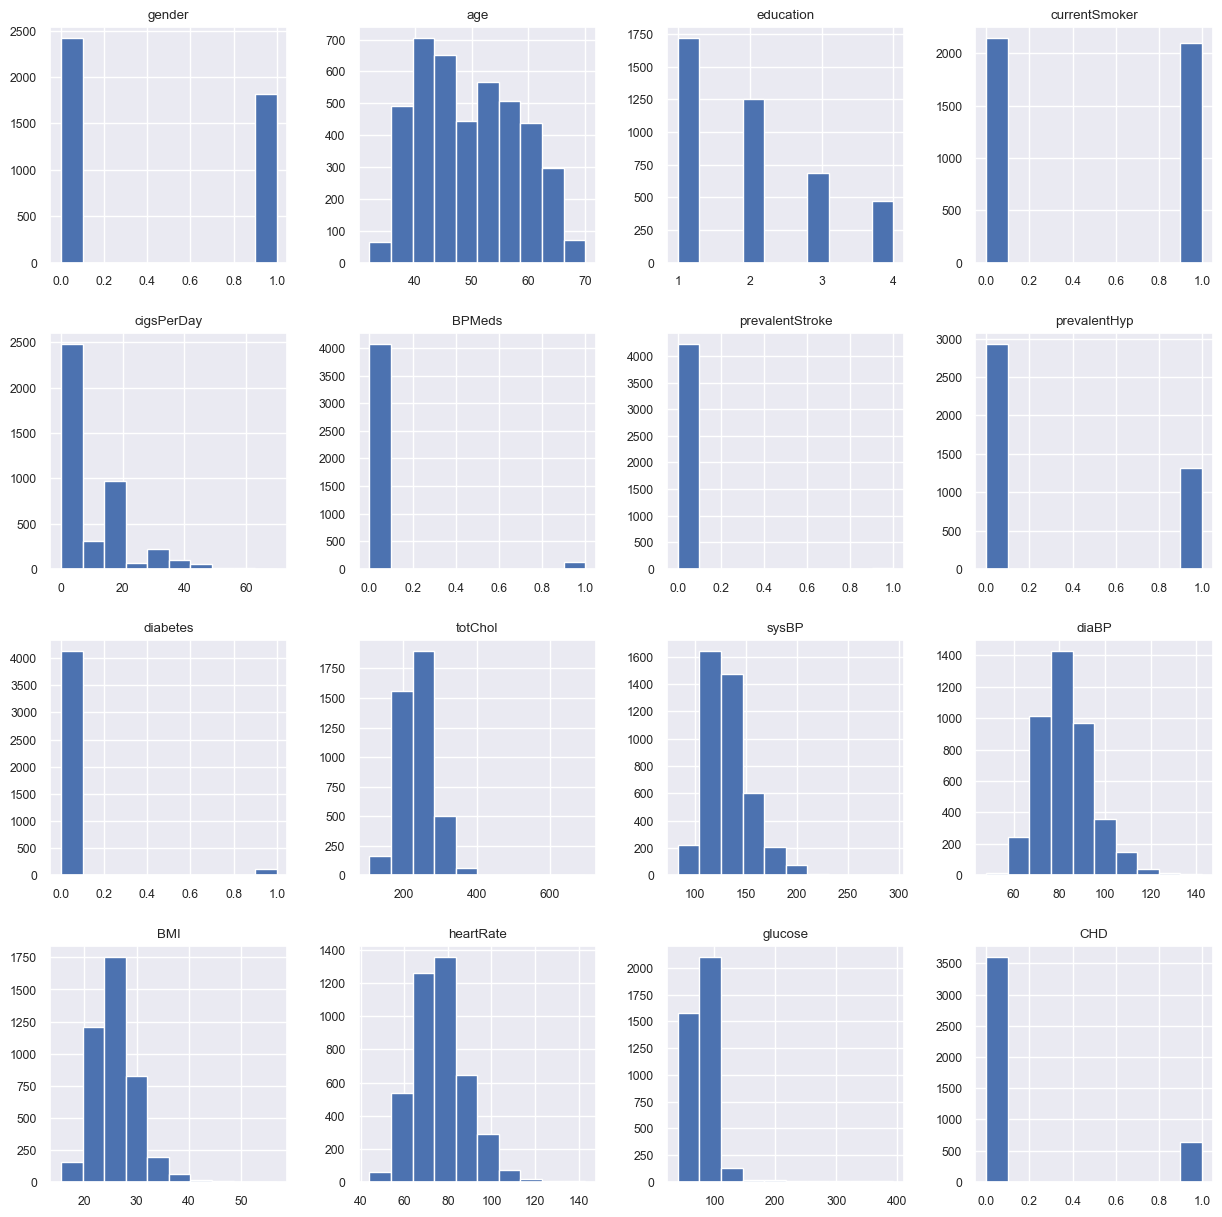

In [14]:
fig = plt.figure(figsize = (15,15))
chd_raw.hist(ax = fig.gca())
plt.show()

Interpretation of the result:

-
-


# Data Cleaning

Then we're checking how many duplicates there are in our dataset

In [15]:
chd_raw.duplicated().sum()

0

There's 0 so nothing to do with this

Finding how many columns that have missing values

In [16]:
missing_rows = chd_raw.isna().any(axis=1).sum()
missing_rows

582

In [17]:
null_counts = chd_raw.isna().sum()
null_counts

gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
CHD                  0
dtype: int64

Finding how many columns that have more than 1 missing value in the same row

In [18]:
more_than_one_missing = chd_raw.isna().sum(axis=1)>1
more_than_one_missing_count = more_than_one_missing.sum()
more_than_one_missing_count

61

Result: we want to drop the rows that have more than 1 missing value, because 61 rows is very little compared to over 4000 instances

Here we're dropping the rows that have more than 1 missing value

In [19]:
chd_df = chd_raw.dropna(thresh=len(chd_raw.columns)-1)

In [20]:
chd_df.isnull().sum()

gender               0
age                  0
education           93
currentSmoker        0
cigsPerDay          23
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              9
sysBP                0
diaBP                0
BMI                 13
heartRate            1
glucose            331
CHD                  0
dtype: int64

We're dropping the variable 'education' because there's no explanation of the numbers in the column

In [21]:
chd_df.drop(['education'], axis=1, inplace=True)

In [22]:
chd_df.isnull().sum()

gender               0
age                  0
currentSmoker        0
cigsPerDay          23
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              9
sysBP                0
diaBP                0
BMI                 13
heartRate            1
glucose            331
CHD                  0
dtype: int64

Now we're filling in the rest of the missing values - decision between mode, mean or median is based on the histograms above 

In [23]:
chd_df['cigsPerDay'].fillna(chd_df['cigsPerDay'].mode()[0], inplace=True)
chd_df['BPMeds'].fillna(chd_df['BPMeds'].mode()[0], inplace=True)
chd_df['totChol'].fillna(chd_df['totChol'].median(), inplace=True)  
chd_df['BMI'].fillna(chd_df['BMI'].median(), inplace=True)
chd_df['heartRate'].fillna(chd_df['heartRate'].mean(), inplace=True) 
chd_df['glucose'].fillna(chd_df['glucose'].median(), inplace=True)

In [24]:
chd_df.isnull().sum()

gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
CHD                0
dtype: int64

Here, we want to create binary columns for those with outliers

In [25]:
chd_df['high_heartRate'] = (chd_df['heartRate'] >= 75).astype(int)
chd_df['high_cigsPerDay'] = (chd_df['cigsPerDay'] >= 17).astype(int)
chd_df['high_totChol'] = (chd_df['totChol'] >= 225).astype(int)

chd_df.drop(['heartRate', 'cigsPerDay', 'totChol'] , axis=1, inplace=True)

chd_df = chd_df[["gender","age","currentSmoker","BPMeds","prevalentStroke","prevalentHyp","diabetes","sysBP","diaBP","BMI","glucose","high_heartRate", "high_cigsPerDay", "high_totChol", "CHD"]]


In [26]:
chd_df.head()

,gender,age,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,glucose,high_heartRate,high_cigsPerDay,high_totChol,CHD
0,1,39,0,0.0,0,0,0,106.0,70.0,26.97,77.0,1,0,0,0
1,0,46,0,0.0,0,0,0,121.0,81.0,28.73,76.0,1,0,1,0
2,1,48,1,0.0,0,0,0,127.5,80.0,25.34,70.0,1,1,1,0
3,0,61,1,0.0,0,1,0,150.0,95.0,28.58,103.0,0,1,1,1
4,0,46,1,0.0,0,0,0,130.0,84.0,23.10,85.0,1,1,1,0


Look at new histograms after binary

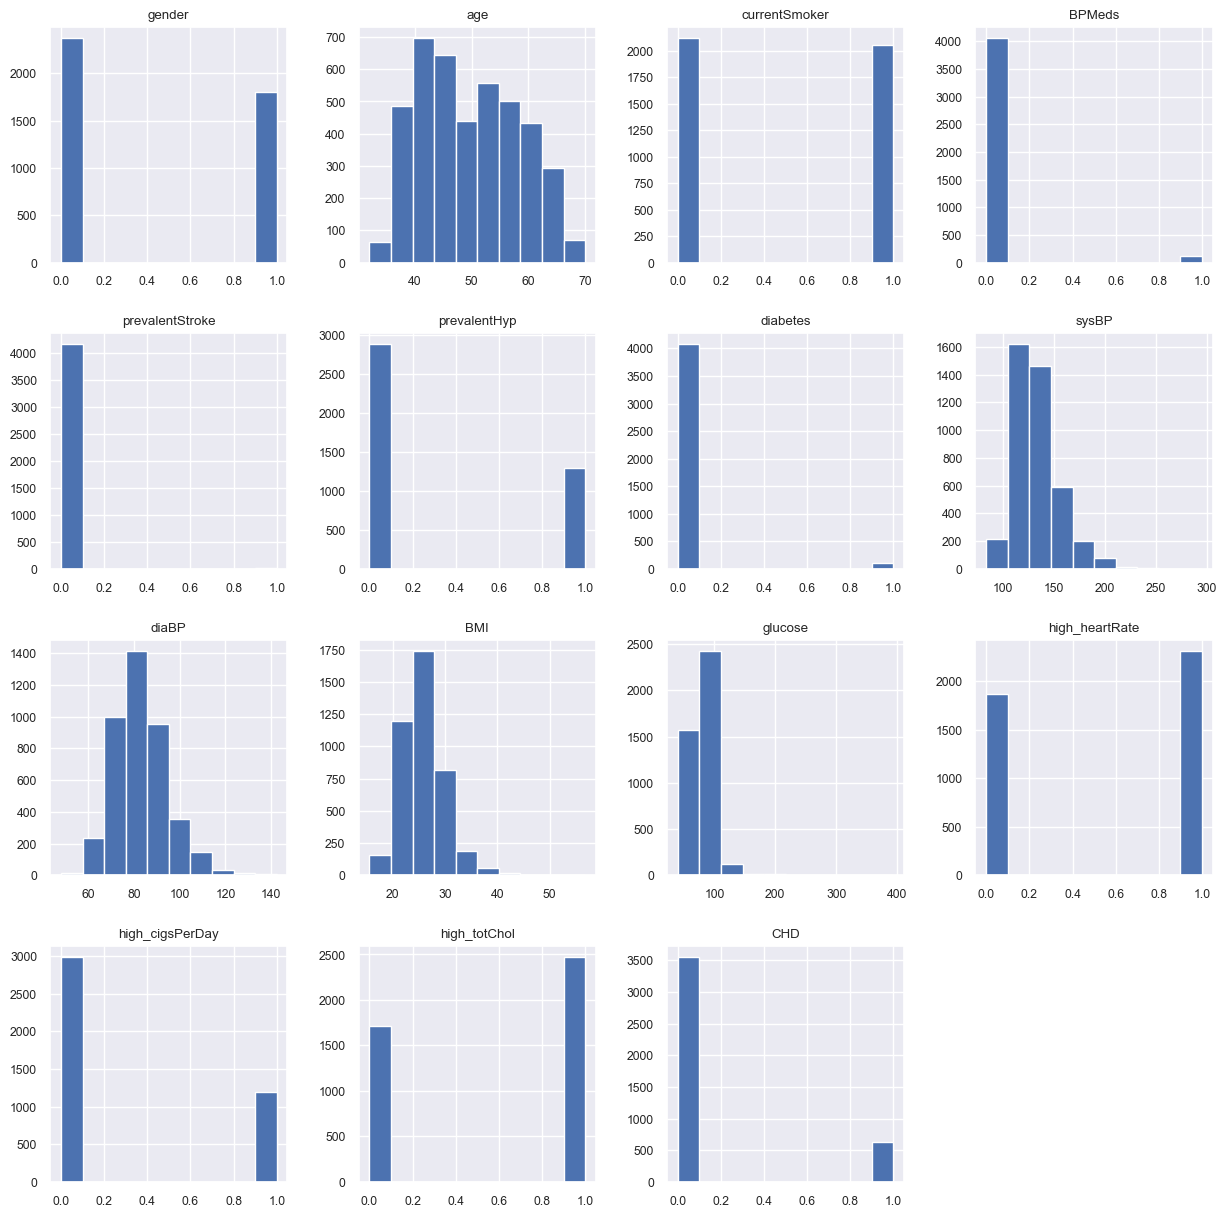

In [27]:
fig = plt.figure(figsize = (15,15))
chd_df.hist(ax = fig.gca())
plt.show()

# Feature Selection

Here we're checking which variables that have the strongest correlation with the target variable with SelectKBest and Chi2

In [28]:
X = chd_df.iloc[:,0:14]  
y = chd_df.iloc[:,-1]    

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(14,'Score'))

              Specs       Score
7             sysBP  719.013887
10          glucose  409.143289
1               age  332.288330
8             diaBP  149.101337
5      prevalentHyp   89.778295
6          diabetes   34.659164
3            BPMeds   28.228355
0            gender   19.193813
4   prevalentStroke   16.240656
9               BMI   15.681742
12  high_cigsPerDay    9.719548
13     high_totChol    5.462418
2     currentSmoker    0.959286
11   high_heartRate    0.034481


In [29]:
X.head()

,gender,age,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,glucose,high_heartRate,high_cigsPerDay,high_totChol
0,1,39,0,0.0,0,0,0,106.0,70.0,26.97,77.0,1,0,0
1,0,46,0,0.0,0,0,0,121.0,81.0,28.73,76.0,1,0,1
2,1,48,1,0.0,0,0,0,127.5,80.0,25.34,70.0,1,1,1
3,0,61,1,0.0,0,1,0,150.0,95.0,28.58,103.0,0,1,1
4,0,46,1,0.0,0,0,0,130.0,84.0,23.10,85.0,1,1,1


Based on the above results we have chosen to drop 1, 2, 3 as they have Julie has notes on this

In [30]:
chd_df.head()

,gender,age,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,glucose,high_heartRate,high_cigsPerDay,high_totChol,CHD
0,1,39,0,0.0,0,0,0,106.0,70.0,26.97,77.0,1,0,0,0
1,0,46,0,0.0,0,0,0,121.0,81.0,28.73,76.0,1,0,1,0
2,1,48,1,0.0,0,0,0,127.5,80.0,25.34,70.0,1,1,1,0
3,0,61,1,0.0,0,1,0,150.0,95.0,28.58,103.0,0,1,1,1
4,0,46,1,0.0,0,0,0,130.0,84.0,23.10,85.0,1,1,1,0


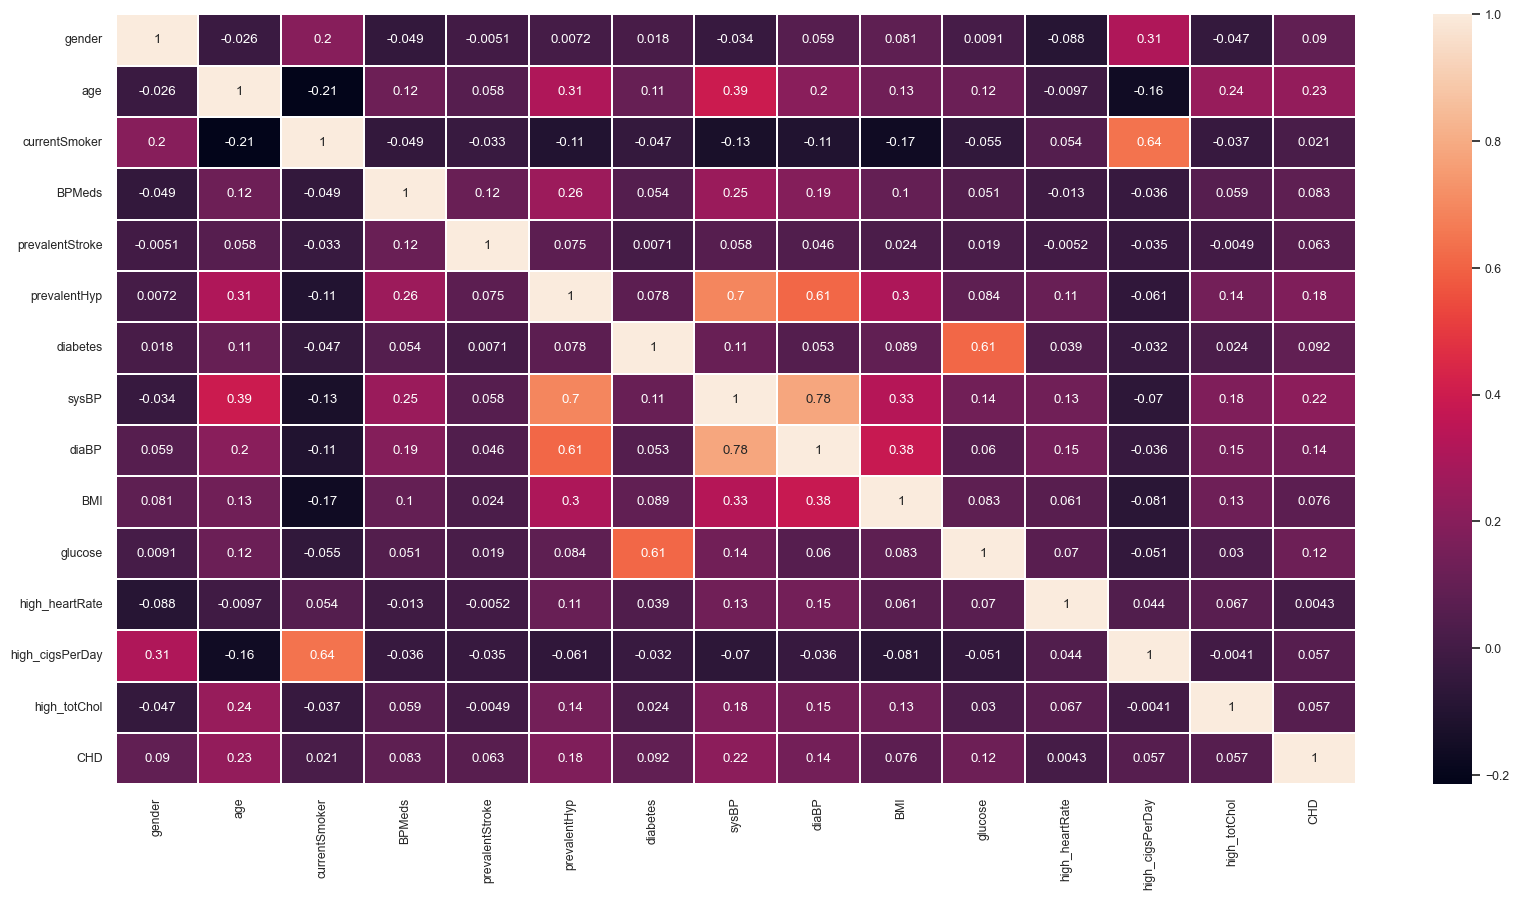

In [31]:
plt.figure(figsize=(20,10))
sns.heatmap(chd_df.corr(),linewidths=0.1,annot=True)
# linewidths is white space between boxes and annot gives value
plt.show()

In [32]:
X = chd_df.iloc[:,:-1]
y = chd_df['CHD']

In [33]:
X.head()

,gender,age,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,glucose,high_heartRate,high_cigsPerDay,high_totChol
0,1,39,0,0.0,0,0,0,106.0,70.0,26.97,77.0,1,0,0
1,0,46,0,0.0,0,0,0,121.0,81.0,28.73,76.0,1,0,1
2,1,48,1,0.0,0,0,0,127.5,80.0,25.34,70.0,1,1,1
3,0,61,1,0.0,0,1,0,150.0,95.0,28.58,103.0,0,1,1
4,0,46,1,0.0,0,0,0,130.0,84.0,23.10,85.0,1,1,1


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42, stratify=y)
print(("Xtrain", X_train.shape, "y_train", 
      y_train.shape, "X_test", X_test.shape, "y_test", y_test.shape))

('Xtrain', (3134, 14), 'y_train', (3134,), 'X_test', (1045, 14), 'y_test', (1045,))


In [35]:
X.head()

,gender,age,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes,sysBP,diaBP,BMI,glucose,high_heartRate,high_cigsPerDay,high_totChol
0,1,39,0,0.0,0,0,0,106.0,70.0,26.97,77.0,1,0,0
1,0,46,0,0.0,0,0,0,121.0,81.0,28.73,76.0,1,0,1
2,1,48,1,0.0,0,0,0,127.5,80.0,25.34,70.0,1,1,1
3,0,61,1,0.0,0,1,0,150.0,95.0,28.58,103.0,0,1,1
4,0,46,1,0.0,0,0,0,130.0,84.0,23.10,85.0,1,1,1


# Baseline Classifier

In [36]:
dm = DummyClassifier()
dm.fit(X_train, y_train)
dm_y_pred = dm.predict(X_test)

print("Accuracy on training set: {:.10f}".format(dm.score(X_train, y_train)))
print("Accuracy on test set: {:.10f}".format(dm.score(X_test, y_test)))

Accuracy on training set: 0.8487555839
Accuracy on test set: 0.8488038278


In [37]:
sum(y)/len(y)

0.15123235223737735

15% of all values = CHD

In [38]:
print(classification_report(y_test, dm_y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       887
           1       0.00      0.00      0.00       158

    accuracy                           0.85      1045
   macro avg       0.42      0.50      0.46      1045
weighted avg       0.72      0.85      0.78      1045



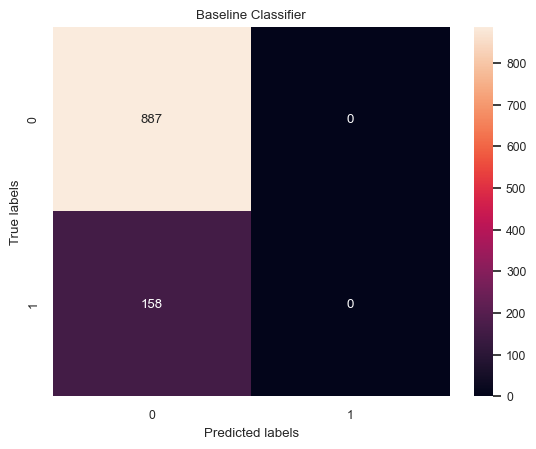

In [39]:
cm_b = confusion_matrix(y_test, dm_y_pred)
ax= plt.subplot()
sns.heatmap(cm_b,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Baseline Classifier');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

The dummy classifier is only predicting y=0 (no CHD) and thus getting 85% accuracy. Therefore, accuracy is not a good indicator of the classifier performance beacause it is so imbalanced. The classifier is incorrectly classifying all cases of CHD as NO CHD = bad!

In [40]:
from collections import Counter
from imblearn.over_sampling import SMOTE

from collections import Counter
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train) 


print('Without SMOTE')

print('Distribution of No CHD (0) and CHD (1) in target variable in training set %s' % Counter(y_train))
print(f'''Shape of X: {X_train.shape}
Shape of y: {y_train.shape}''')
print('')

print('Re-sampled dataset - With SMOTE')
print('Distribution of No CHD (0) and CHD (1) in target variable in training set %s ' % Counter(y_res))

print(f'''Shape of X: {X_res.shape}
Shape of y: {y_res.shape}''')


Without SMOTE
Distribution of No CHD (0) and CHD (1) in target variable in training set Counter({0: 2660, 1: 474})
Shape of X: (3134, 14)
Shape of y: (3134,)

Re-sampled dataset - With SMOTE
Distribution of No CHD (0) and CHD (1) in target variable in training set Counter({0: 2660, 1: 2660}) 
Shape of X: (5320, 14)
Shape of y: (5320,)


In [41]:
sum(y_res)/len(y_res)

0.5

# Logistic Regression

WITHOUT SMOTE

In [42]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
log_reg_y_pred = log_reg.predict(X_test)
print("Score on training set: {:.3f}".format(log_reg.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(log_reg.score(X_test, y_test)))

Score on training set: 0.856
Score on test set: 0.856


WITH SMOTE

In [43]:
log_reg_sm = LogisticRegression(max_iter=2000)
log_reg_sm.fit(X_res, y_res)
log_reg_sm_y_pred = log_reg_sm.predict(X_test)
print("Accuracy on training set: {:.3f}".format(log_reg_sm.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(log_reg_sm.score(X_test, y_test)))

Accuracy on training set: 0.688
Accuracy on test set: 0.691


WITHOUT SMOTE

In [44]:
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       887
           1       0.68      0.09      0.17       158

    accuracy                           0.86      1045
   macro avg       0.77      0.54      0.54      1045
weighted avg       0.83      0.86      0.81      1045



- Precision measures the accuracy of positive predictions. The model has a high precision (0.84) for predicting no CHD, meaning that when the model predicts that a patient will not have a CHD, it is correct 84% of the time. However, the precision is much lower for predicting stroke (0.5), meaning that when the model predicts a CHD, it is correct only 50% of the time

- Recall (also known as sensitivity or true positive rate) measures the fraction of positives that were correctly identified. The model has a recall of 1.0 for no CHD and 0.02 for CHD. This means that the model correctly identifies 100% of the patients who will not have a CHD and 0.2% of the patients who will have a CHD. The lower recall for CHD indicates that the model is missing a large number of patients who will have a CHD.

- The F1 score is a weighted average of precision and recall. The F1 scores for no CHD and CHD are 0.91 and 0.03, respectively. The low F1 score for CHD indicates that the model's performance is very poor when it comes to predicting CHD.

- The accuracy of the model is 0.84, which means that the model correctly predicts whether a patient will have a CHD or not in 84% of the cases. However, accuracy can be misleading when dealing with imbalanced classes, as it is in this case.

WITH SMOTE

In [45]:
print(classification_report(y_test, log_reg_sm_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       887
           1       0.25      0.51      0.33       158

    accuracy                           0.69      1045
   macro avg       0.57      0.62      0.57      1045
weighted avg       0.79      0.69      0.73      1045



It's evident that the recall and F1 score for predicting CHD correctly is much better with SMOTE.
The most important metric to consider and base deployment decisions on is probably recall of class label 1 (i.e., where patients do have CHD) --> They outperform the dummy classifier, which returns a recall of 0.00 

Confusion matrix WITHOUT SMOTE

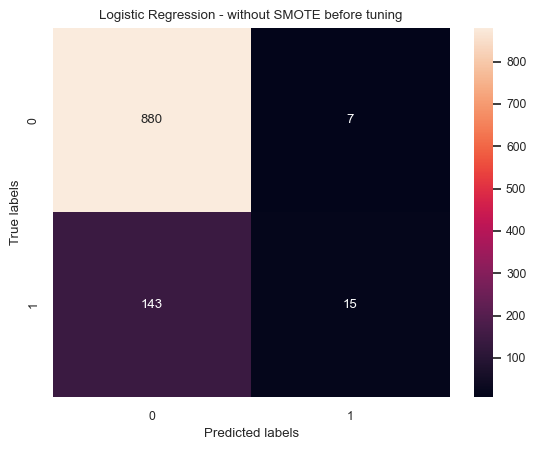

In [46]:
cm1 = confusion_matrix(y_test, log_reg.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm1,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - without SMOTE before tuning');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);


144 people are false negative = not so good

Confusion matrix WITH SMOTE

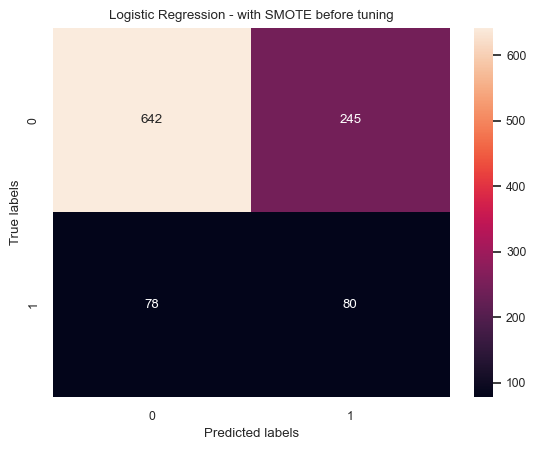

In [47]:
cm2 = confusion_matrix(y_test,log_reg_sm.predict(X_test))
ax= plt.subplot()
sns.heatmap(cm2,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression - with SMOTE before tuning');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

ROC WITHOUT SMOTE

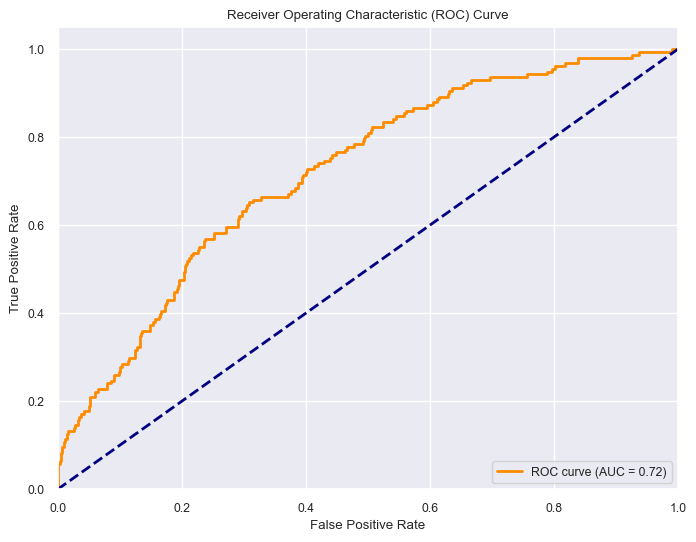

In [48]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob = log_reg.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

This ROC value indicates a poor performance - there is a 72% chance that the model will be able to distinguish between positive class and negative class

ROC WITH SMOTE

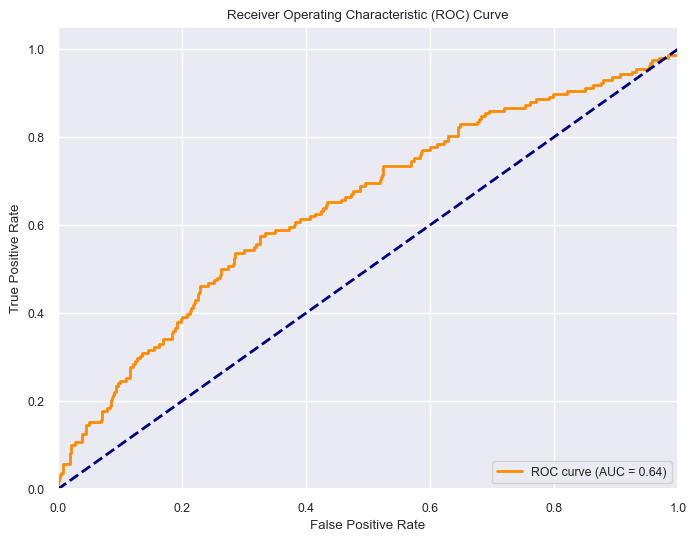

In [49]:
# Step 1: Compute the predicted probabilities for the positive class
y_prob_sm = log_reg_sm.predict_proba(X_test)[:,1]

# Step 2: Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sm)

# Step 3: Compute the AUC
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Finding hyperparameters for log reg using RandomSearch

Without SMOTE

In [50]:
parameters = {
    'max_iter' : (2000, 4000, 6000, 8000),
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg','lbfgs','sag','saga'],
}


log_reg_tuned_pipeline  = make_pipeline(StandardScaler(),
                                     RandomizedSearchCV(LogisticRegression(), 
                                                        random_state = None,
                                                        param_distributions=parameters,
                                                        cv = 5,                            
                                                        verbose = 1,            
                                                        scoring = 'recall'))               

# Fitting model with optimized parameters to training set
log_reg_tuned = log_reg_tuned_pipeline.fit(X_train,y_train)

# Identifying the most optimal hyperparameters
log_reg_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 8000, 'C': 1000.0}

With SMOTE

In [51]:
parameters = {
    'max_iter' : (2000, 4000, 6000, 8000),
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg','lbfgs','sag','saga'],
}


log_reg_tuned_pipeline_sm  = make_pipeline(StandardScaler(),
                                           SMOTE(),
                                             RandomizedSearchCV(LogisticRegression(), 
                                                        random_state = None,
                                                        param_distributions=parameters,
                                                        cv = 5,                            
                                                        verbose = 1,            
                                                        scoring = 'recall'))               

# Fitting model with optimized parameters to training set
log_reg_tuned_sm = log_reg_tuned_pipeline.fit(X_res,y_res)

# Identifying the most optimal hyperparameters
log_reg_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 6000, 'C': 0.1}

# Tuning the Logistic Regression model using RandomSearch

Accuracy WITHOUT SMOTE

In [52]:
# Tuning model with optimized hyperparameters
log_reg_tuned = LogisticRegression(solver='newton-cg', max_iter=8000, penalty='l2', C= 1000.0)

# Train - Fitting model to training set 
log_reg_tuned.fit(X_train, y_train)

# Predict y using test set
y_log_reg_tuned = log_reg_tuned.predict(X_test)

# Reporting test scores
print("Accuracy on training set without SMOTE: {:.3f}".format(log_reg_tuned.score(X_train, y_train)))
print("Accuracy on test set without SMOTE: {:.3f}".format(log_reg_tuned.score(X_test, y_test)))

Accuracy on training set without SMOTE: 0.856
Accuracy on test set without SMOTE: 0.856


Classification report WITHOUT SMOTE

In [53]:
    print(classification_report(y_test, y_log_reg_tuned))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       887
           1       0.68      0.09      0.17       158

    accuracy                           0.86      1045
   macro avg       0.77      0.54      0.54      1045
weighted avg       0.83      0.86      0.81      1045



Confusion matrix without SMOTE

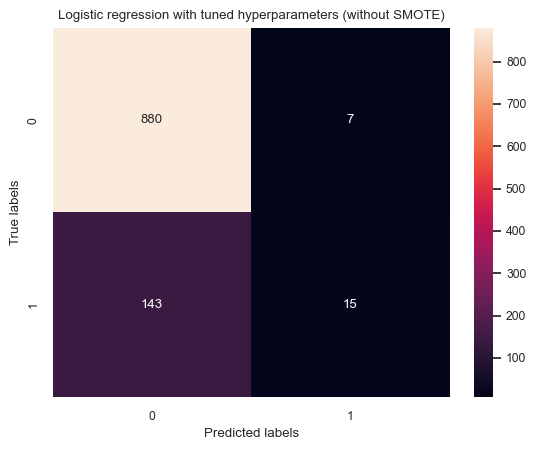

In [54]:
cm3 = confusion_matrix(y_test, y_log_reg_tuned)
ax= plt.subplot()
        
sns.heatmap(cm3,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic regression with tuned hyperparameters (without SMOTE)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Accuracy WITH SMOTE

In [55]:
# Tuning model with optimized hyperparameters
log_reg_sm_tuned = LogisticRegression(solver='newton-cg', max_iter=4000, penalty='l2', C= 0.1)

# Train - Fitting model to training set 
log_reg_sm_tuned.fit(X_train, y_train)

# Predict y using test set
y_log_reg_sm_tuned = log_reg_tuned_sm.predict(X_test)

# Reporting test scores
print("Accuracy on training set with SMOTE: {:.3f}".format(log_reg_sm_tuned.score(X_res, y_res)))
print("Accuracy on test set without SMOTE: {:.3f}".format(log_reg_sm_tuned.score(X_test, y_test)))

Accuracy on training set with SMOTE: 0.512
Accuracy on test set without SMOTE: 0.858


Classification report WITH SMOTE

In [56]:
print(classification_report(y_test, y_log_reg_sm_tuned))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       887
           1       0.24      0.50      0.33       158

    accuracy                           0.69      1045
   macro avg       0.57      0.61      0.56      1045
weighted avg       0.79      0.69      0.73      1045



Confusion matrix with SMOTE

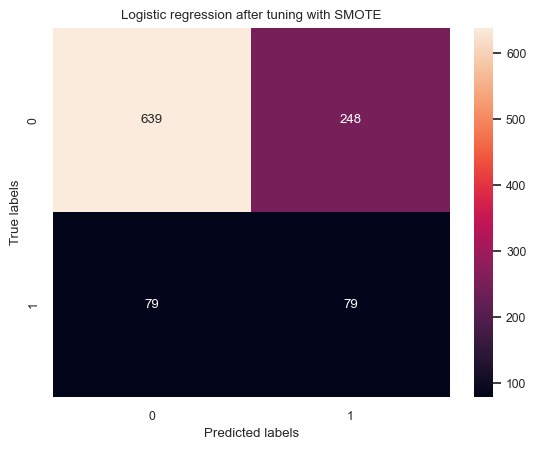

In [57]:
cm4 = confusion_matrix(y_test, y_log_reg_sm_tuned)
ax= plt.subplot()
        
sns.heatmap(cm4,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic regression after tuning with SMOTE');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# Random Forest

WITHOUT SMOTE 

In [58]:
#Tune the model using the RandomForestClassifier with max_depth 10
rf = RandomForestClassifier(n_estimators = 500, max_depth=8, random_state=5)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test) 

#Print accuracy
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.874
Accuracy on test set: 0.852


Classification report WITHOUT SMOTE

In [59]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       887
           1       0.80      0.03      0.05       158

    accuracy                           0.85      1045
   macro avg       0.83      0.51      0.48      1045
weighted avg       0.84      0.85      0.79      1045



WITH SMOTE

In [60]:
#Tune the model using the RandomForestClassifier with max_depth 10
rf_sm = RandomForestClassifier(n_estimators = 500, max_depth=8, random_state=5)
rf_sm.fit(X_res, y_res)
rf_sm_y_pred = rf_sm.predict(X_test) 

#Print accuracy
print("Accuracy on training set: {:.3f}".format(rf_sm.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(rf_sm.score(X_test, y_test)))

Accuracy on training set: 0.825
Accuracy on test set: 0.748


In [61]:
#Print scores
simple_scores = cross_val_score(log_reg, X, y, cv=10, scoring='r2')
simple_scores

array([-0.19615471, -0.04663537, -0.12139504, -0.10270512, -0.14008495,
       -0.17746479, -0.06532529, -0.12544138, -0.14389124, -0.2527576 ])

In [62]:
#Print more scores
print("The average test score is:", simple_scores.mean())
print("The standard deviation of the test scores is:", simple_scores.std())

The average test score is: -0.1371855485549834
The standard deviation of the test scores is: 0.05783549868833071


Classification report WITH SMOTE 

In [63]:
print(classification_report(y_test, rf_sm_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       887
           1       0.27      0.39      0.32       158

    accuracy                           0.75      1045
   macro avg       0.58      0.60      0.58      1045
weighted avg       0.79      0.75      0.77      1045



Confusion matrix without SMOTE

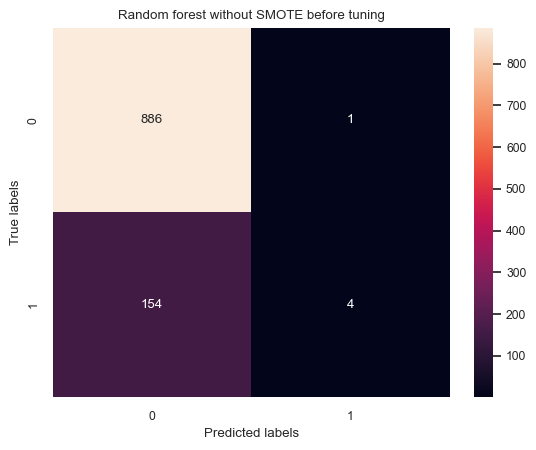

In [64]:
cm11 = confusion_matrix(y_test,rf_y_pred)
ax= plt.subplot()
sns.heatmap(cm11,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random forest without SMOTE before tuning');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Confusion matrix with SMOTE

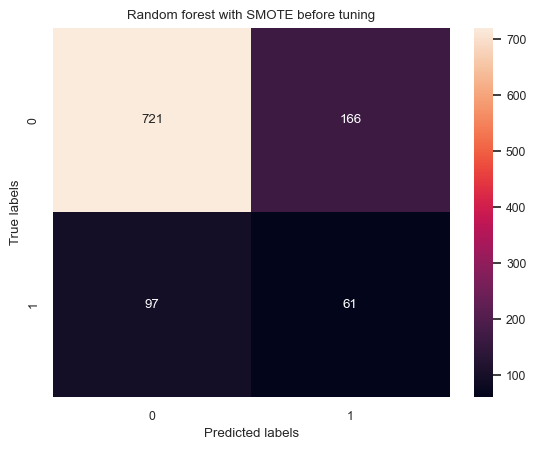

In [65]:
cm12 = confusion_matrix(y_test,rf_sm_y_pred)
ax= plt.subplot()
sns.heatmap(cm12,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random forest with SMOTE before tuning');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Finding hyperparameters for Random Forest using RandomSearch

In [66]:
# Using RandomizedSearchCV to optimize hyperparameters for Random Forest Classifier
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)] # Returns array with 10 random values between 10 and 80


# Creating the parameter grid with parameters to search through
param_grid = {'n_estimators': n_estimators, # Number of trees in random forest
               'max_depth': [100, 150, 190, 240, 300, 400, None], # Maximum number of levels in tree
               "criterion": ["gini", "entropy"],
               "class_weight" : ['balanced', None, {0: 1, 1: 3}]}

Without SMOTE

In [67]:
# Implementing RandomizedSearchCV for the model
rf_tuned_pipeline  = make_pipeline(StandardScaler(), 
                                    RandomizedSearchCV(RandomForestClassifier(), 
                                                       random_state = 5, param_distributions = param_grid, 
                                                       cv = 5, verbose = True, scoring = 'recall'))

# Fitting model to training set
rf_tuned = rf_tuned_pipeline.fit(X_train,y_train)

# Identifying the optimal hyperparameters
rf_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 17,
 'max_depth': 400,
 'criterion': 'gini',
 'class_weight': None}

With SMOTE

In [68]:
# Implementing RandomizedSearchCV for the model
rf_sm_tuned_pipeline  = make_pipeline(StandardScaler(), 
                                       RandomizedSearchCV(RandomForestClassifier(), 
                                                          random_state = 15, param_distributions = param_grid, 
                                                          cv = 5, verbose = True, scoring = 'recall'))

# Fitting model to training set
rf_sm_tuned = rf_sm_tuned_pipeline.fit(X_res,y_res)

# Identifying the optimal hyperparameters
rf_sm_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 64,
 'max_depth': 190,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

# Tuning the Random Forest model using RandomSearch

Accuracy without SMOTE

In [69]:
# Tuning model with optimized hyperparameters
rf_tuned = RandomForestClassifier(
    random_state=5,
    n_estimators=17, 
    max_depth=400, 
    criterion= 'gini',
    class_weight=None)

# Train - Fitting model to training set 
rf_tuned.fit(X_train, y_train)

# Predict y using test set
y_rf_pred_tuned = rf_tuned.predict(X_test)


print("Accuracy on training set: {:.3f}".format(rf_tuned.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(rf_tuned.score(X_test, y_test)))

Accuracy on training set: 0.703
Accuracy on test set: 0.841


Classification report without SMOTE 

In [70]:
print(classification_report(y_test, y_rf_pred_tuned))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       887
           1       0.39      0.09      0.14       158

    accuracy                           0.84      1045
   macro avg       0.62      0.53      0.53      1045
weighted avg       0.79      0.84      0.80      1045



Confusion metrix WITHOUT SMOTE

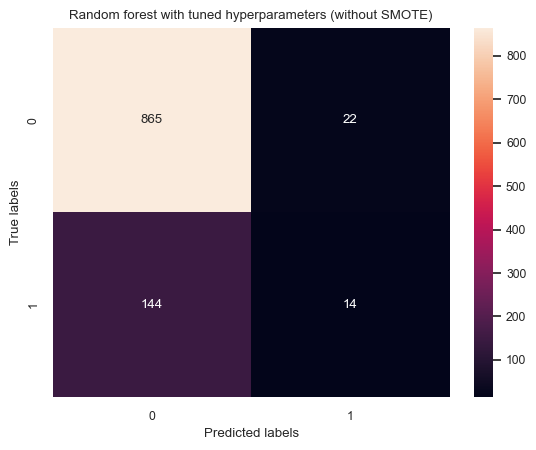

In [71]:
cm5 = confusion_matrix(y_test, y_rf_pred_tuned)
ax= plt.subplot()
        
sns.heatmap(cm5,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random forest with tuned hyperparameters (without SMOTE)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
   

Accuracy with SMOTE

In [72]:
# Tuning model with optimized hyperparameters
rf_sm_tuned = RandomForestClassifier(
    random_state=5,
    n_estimators=33, 
    max_depth=100,     
    criterion= 'entropy',
    class_weight='balanced')

# Train - Fitting model to training set 
rf_sm_tuned.fit(X_res, y_res)

# Predict y using test set
y_rf_sm_pred_tuned= rf_sm_tuned.predict(X_test)

print("Accuracy on training set: {:.3f}".format(rf_sm_tuned.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(rf_sm_tuned.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.787


Classifciation report WITH SMOTE 

In [73]:
print(classification_report(y_test, y_rf_sm_pred_tuned))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       887
           1       0.29      0.28      0.28       158

    accuracy                           0.79      1045
   macro avg       0.58      0.58      0.58      1045
weighted avg       0.78      0.79      0.79      1045



Confusion matrix WITH SMOTE 

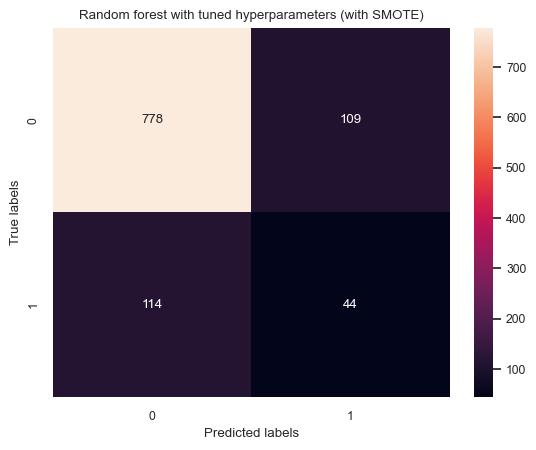

In [74]:
cm6 = confusion_matrix(y_test, y_rf_sm_pred_tuned)
ax= plt.subplot()
        
sns.heatmap(cm6,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random forest with tuned hyperparameters (with SMOTE)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# KNN Classification

KNN WITHOUT SMOTE

In [75]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_kn_pred = kn.predict(X_test)
print("Accuracy on training set: {:.3f}".format(kn.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(kn.score(X_test, y_test)))

Accuracy on training set: 0.862
Accuracy on test set: 0.839


Classification report WITHOUT SMOTE

In [76]:
print(classification_report(y_test, y_kn_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       887
           1       0.36      0.08      0.13       158

    accuracy                           0.84      1045
   macro avg       0.61      0.53      0.52      1045
weighted avg       0.78      0.84      0.79      1045



KNN WITH SMOTE

In [77]:
kn_sm = KNeighborsClassifier(n_neighbors=190)
kn_sm.fit(X_res, y_res)
y_kn_sm_pred = kn_sm.predict(X_test)
print("Accuracy on training set: {:.3f}".format(kn_sm.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(kn_sm.score(X_test, y_test)))

Accuracy on training set: 0.640
Accuracy on test set: 0.655


Classification report WITH SMOTE

In [78]:
print(classification_report(y_test, y_kn_sm_pred))

              precision    recall  f1-score   support

           0       0.91      0.66      0.76       887
           1       0.25      0.65      0.36       158

    accuracy                           0.65      1045
   macro avg       0.58      0.65      0.56      1045
weighted avg       0.81      0.65      0.70      1045



Confusion matrix WITHOUT SMOTE

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

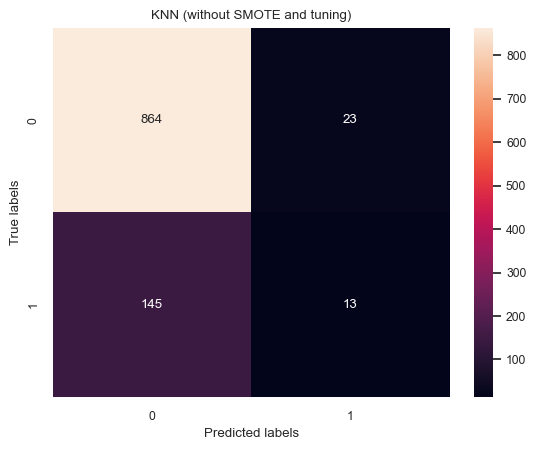

In [79]:
cm7 = confusion_matrix(y_test,y_kn_pred)
ax= plt.subplot()
sns.heatmap(cm7,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN (without SMOTE and tuning)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

Confusion matrix WITH SMOTE

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

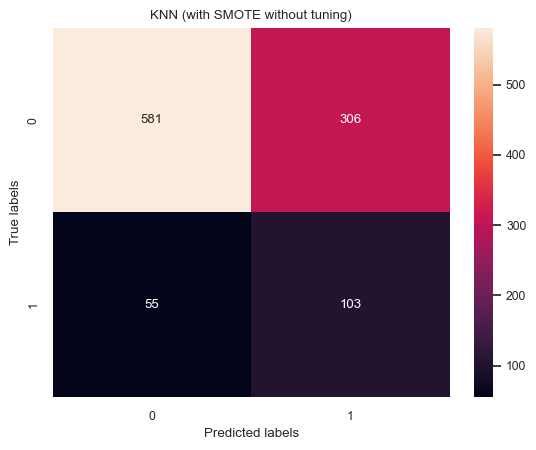

In [80]:
cm8 = confusion_matrix(y_test,y_kn_sm_pred)
ax= plt.subplot()
sns.heatmap(cm8,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN (with SMOTE without tuning)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

Finding hyperparameters for KNN

In [81]:
parameters = {'n_neighbors' : range(1, 300),
             'weights' : ('uniform', 'distance'),
             'p': [1, 2]}

WITHOUT SMOTE

In [82]:
# Creating models through RandomizedSearchCV with Standardscaler for datasets with and without SMOTE
kn_tuned_pipeline  = make_pipeline(StandardScaler(), 
                                    RandomizedSearchCV(KNeighborsClassifier(), 
                                                       random_state = 5, param_distributions = parameters, 
                                                       cv = 5, verbose = True, scoring = 'recall'))
# Fitting model to training set
kn_tuned = kn_tuned_pipeline.fit(X_train,y_train)

# Identifying the most optimal hyperparameters
kn_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'weights': 'distance', 'p': 1, 'n_neighbors': 19}

WITH SMOTE

In [83]:
# Creating models through RandomizedSearchCV with Standardscaler for datasets with and without SMOTE
kn_sm_tuned_pipeline  = make_pipeline(StandardScaler(), 
                                       RandomizedSearchCV(KNeighborsClassifier(), 
                                                          random_state = 5, param_distributions = parameters, 
                                                          cv = 5, verbose = True, scoring = 'recall'))
# Fitting model to training set
kn_sm_tuned = kn_sm_tuned_pipeline.fit(X_res,y_res)

# Identifying the most optimal hyperparameters
kn_sm_tuned[1].best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'weights': 'distance', 'p': 1, 'n_neighbors': 19}

# Tuning the KNN classifier using RandomSearch

Without SMOTE

In [84]:
# Building optimized model using the identifyed hyperparameters
kn_tuned = KNeighborsClassifier(weights='distance',n_neighbors=1)

# Train - Fitting model to training set 
kn_tuned.fit(X_train, y_train)

# Predict y using test set
y_kn_pred_tuned = kn_tuned.predict(X_test)

print("Accuracy on training set: {:.3f}".format(kn_tuned.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(kn_tuned.score(X_test, y_test)))

Accuracy on training set: 0.946
Accuracy on test set: 0.785


Classification table without SMOTE

In [85]:
print(classification_report(y_test,y_kn_pred_tuned))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       887
           1       0.26      0.23      0.25       158

    accuracy                           0.78      1045
   macro avg       0.56      0.56      0.56      1045
weighted avg       0.77      0.78      0.78      1045



Confusion matrix without SMOTE

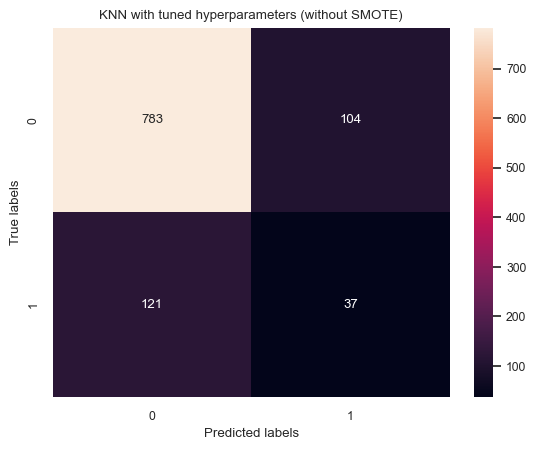

In [86]:
cm9 = confusion_matrix(y_test, y_kn_pred_tuned)
ax= plt.subplot()
        
sns.heatmap(cm9,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN with tuned hyperparameters (without SMOTE)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

With SMOTE

In [87]:
# Building optimized model using the identifyed hyperparameters
kn_sm_tuned = KNeighborsClassifier(weights='distance', p=1, n_neighbors=19)

# Train - Fitting model to training set
kn_sm_tuned.fit(X_res, y_res)

# Predict y using test set
y_kn_sm_pred_tuned = kn_sm_tuned.predict(X_test)

print("Accuracy on training set: {:.3f}".format(kn_sm_tuned.score(X_res, y_res)))
print("Accuracy on test set: {:.3f}".format(kn_sm_tuned.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.637


Classification table with SMOTE

In [88]:
print(classification_report(y_test,y_kn_sm_pred_tuned))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75       887
           1       0.22      0.55      0.31       158

    accuracy                           0.64      1045
   macro avg       0.56      0.60      0.53      1045
weighted avg       0.79      0.64      0.69      1045



Confusion matrix with SMOTE

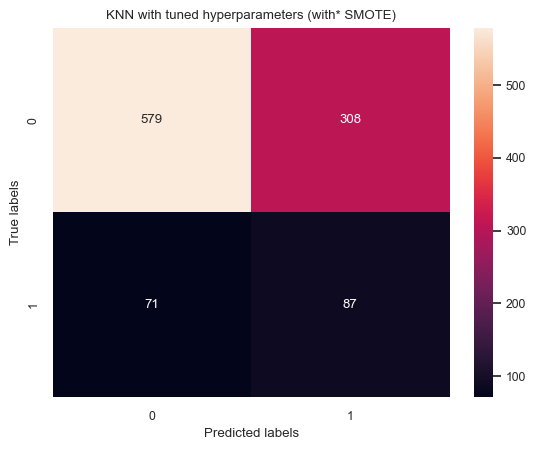

In [89]:
cm10 = confusion_matrix(y_test, y_kn_sm_pred_tuned)
ax= plt.subplot()
        
sns.heatmap(cm10,annot=True, ax = ax, fmt='d')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN with tuned hyperparameters (with* SMOTE)');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);